# DLAV Project - Phase 1

In this notebook we will train a very simple planner on data coming from a driving simulator. You are given a dash cam image of the current state of the driving vehicle, and the past positions of this vehicle, and you are asked to plan its future route.

This notebook will take you through steps on building this planner to solve the task. The full skeleton of the code together with some very simple implementations of each module are provided for your comfort. So all the cells below will run without you needing to change anything, but the performance won't be very good. You are asked to re-implement and play with most of the modules yourself to be able to have better performance.

P.S. to enable fast compute, you should use GPUs in google colab. The code works without GPUs, but it'll be much faster to use GPUs, specially if your model gets bigger and bigger! You can utilize Colab's GPUs by selecting "Change runtime type" in the Runtime menu on top of this page. There you can select "T4 GPU". This would restart your runtime, so you'll need to re-run everything from the top.

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [2]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=8f2c8096-9e4e-450c-ba93-1030028549a2
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:01<00:00, 254MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=bc4e31d4-73a3-443e-822f-c5935d0544e5
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:00<00:00, 248MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=a8693aca-46ac-48ba-9496-740875ec9421
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:00<00:00, 215MB/s]


Now lets load the data and visualize the first few examples to see what we are dealing with!

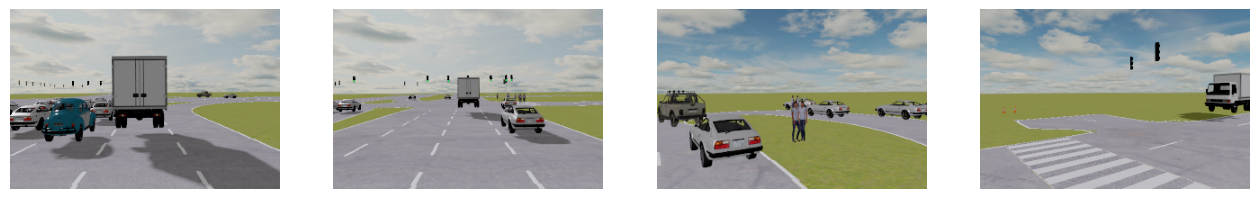

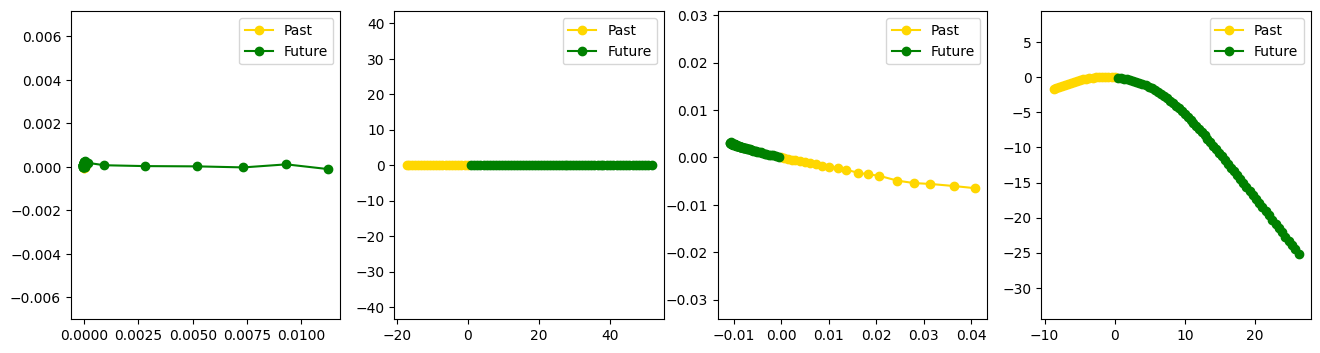

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

In [4]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import pickle
from collections import Counter

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

        self.cmd2idx = {'forward': 0, 'left': 1, 'right': 2}

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
            transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = Image.fromarray(data['camera'].astype(np.uint8))
        camera = self.transform(camera)

        pos_xyh = data['sdc_history_feature'][:, :3]
        vel = np.zeros_like(pos_xyh)
        vel[1:] = pos_xyh[1:] - pos_xyh[:-1]
        acc = np.zeros_like(pos_xyh)
        acc[1:] = vel[1:] - vel[:-1]

        timestep = np.linspace(0, 1, 21).reshape(-1, 1)
        ego_flag = np.ones((21, 1))

        history = np.concatenate([pos_xyh, vel, acc, timestep, ego_flag], axis=1)  # (21, 10)

        cmd_idx = self.cmd2idx[data['driving_command']]

        if not self.test:
            future = data['sdc_future_feature'][:, :3]
            return {
                'camera': camera,
                'history': torch.FloatTensor(history),   # (21, 10)
                'future': torch.FloatTensor(future),     # (60, 3)
                'command': torch.tensor(cmd_idx).long()  # scalar
            }
        else:
            return {
                'camera': camera,
                'history': torch.FloatTensor(history),
                'command': torch.tensor(cmd_idx).long()
            }

In [5]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

In [6]:
import torch
import torch.nn as nn
from torchvision.models import resnet34, resnet18


class TransformerMotionEncoder(nn.Module):
    def __init__(self, input_dim=10, emb_dim=128, num_layers=2, num_heads=4):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.embedding(x)       # (B, T, emb_dim)
        x = self.encoder(x)         # (B, T, emb_dim)
        x = x.transpose(1, 2)       # (B, emb_dim, T)
        x = self.pool(x).squeeze(2) # (B, emb_dim)
        return x


class CASPStylePlanner(nn.Module):
    def __init__(self, future_len=60, mode_num=1, hidden_dim=256):
        super().__init__()
        self.future_len = future_len
        self.mode_num = mode_num
        self.hidden_dim = hidden_dim

        # CNN encoder (ResNet18 backbone)
        resnet = resnet34(pretrained=True)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-2])  # (B, 512, 7, 7)
        self.image_fc = nn.Linear(512 * 7 * 7, hidden_dim)

        # Motion encoder
        self.history_encoder = TransformerMotionEncoder(input_dim=11, emb_dim=128)
        self.motion_proj = nn.Linear(128, hidden_dim)

        # Command embedding
        self.cmd_embedding = nn.Embedding(3, 32)  # 0: forward, 1: left, 2: right

        # Mode embedding (optional)
        self.mode_embedding = nn.Embedding(mode_num, 32)

        # Feature fusion
        self.fusion_fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 32 + 32, hidden_dim),
            nn.ReLU(),
        )

        # GRU decoder
        self.decoder_gru = nn.GRUCell(input_size=hidden_dim + 3, hidden_size=hidden_dim)
        self.pred_head = nn.Linear(hidden_dim, 3)  # Output (Δx, Δy, Δheading)

        # Scheduled sampling
        self.scheduled_sampling_prob = 1.0  # updated externally in training loop

    def forward(self, camera, history, command, mode_id=None, gt_future=None, decode_len=None):
        B = camera.size(0)
        device = camera.device
        decode_len = decode_len or self.future_len

        # --- Encode image ---
        x_img = self.image_encoder(camera)           # (B, 512, 7, 7)
        x_img = x_img.view(B, -1)                    # (B, 512*7*7)
        x_img = self.image_fc(x_img)                 # (B, hidden_dim)

        # --- Encode motion ---
        x_hist = self.history_encoder(history)       # (B, 128)
        x_hist = self.motion_proj(x_hist)            # (B, hidden_dim)

        # --- Command embedding ---
        cmd_embed = self.cmd_embedding(command)      # (B, 32)

        # --- Mode embedding (optional) ---
        if mode_id is None:
            mode_id = torch.zeros(B, dtype=torch.long, device=device)
        mode_embed = self.mode_embedding(mode_id)    # (B, 32)

        # --- Feature fusion ---
        fused_feature = self.fusion_fc(torch.cat([x_img, x_hist, cmd_embed, mode_embed], dim=-1))  # (B, hidden_dim)

        # --- Recurrent Decoder with Scheduled Sampling ---
        outputs = []
        last_pred = torch.zeros(B, 3, device=device)
        h = fused_feature

        # Sampling mask
        if self.training and gt_future is not None:
            use_gt = (torch.rand(B, device=device) < self.scheduled_sampling_prob)

        for t in range(decode_len):
            # Scheduled sampling: use GT or prev pred
            if self.training and gt_future is not None and t > 0:
                step_gt = gt_future[:, t-1, :]  # (B, 3)
                last_pred = torch.where(use_gt.view(-1, 1), step_gt, last_pred)

            decoder_input = torch.cat([fused_feature, last_pred], dim=-1)  # (B, hidden+3)
            h = self.decoder_gru(decoder_input, h)                         # (B, hidden)
            delta = self.pred_head(h)                                      # (B, 3)
            last_pred = last_pred + delta                                  # (B, 3)
            outputs.append(last_pred.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # (B, decode_len, 3)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# --------------------
# DWA (Dynamic Weight Averaging)
# --------------------
class DWAWeightBalancer:
    def __init__(self, loss_names, temp=2.0):
        self.loss_names = loss_names
        self.temp = temp
        self.history = {name: [1.0, 1.0] for name in loss_names}  # Initialize with dummy values

    def update(self, current_losses):
        updated_weights = {}
        for name in self.loss_names:
            l_prev2, l_prev1 = self.history[name]
            r = torch.tensor(l_prev1 / (l_prev2 + 1e-8))
            weight = len(self.loss_names) * torch.exp(r / self.temp)
            updated_weights[name] = weight.item()

        # Normalize so weights sum to 1
        total = sum(updated_weights.values())
        updated_weights = {k: v / total for k, v in updated_weights.items()}

        # Update loss history
        for name in self.loss_names:
            self.history[name][0] = self.history[name][1]
            self.history[name][1] = current_losses.get(name, 1.0)  # fallback if missing

        return updated_weights

# --------------------
# Loss Function
# --------------------
class PlanningLaplaceLossSequential(nn.Module):
    def __init__(self, fixed_b=1.2, weights=None):
        super().__init__()
        self.fixed_b = fixed_b
        self.weights = weights or {
            'laplace': 1.2,
            'heading': 0.8,
            'velocity': 0.1,
            'smoothness': 0.05,
            'curvature': 0.5,
        }

    def heading_to_vec(self, theta):
        return torch.stack([torch.cos(theta), torch.sin(theta)], dim=-1)

    def laplace_nll(self, pred, gt, scale):
        if not torch.is_tensor(scale):
            scale = torch.tensor(scale, device=pred.device, dtype=pred.dtype)
        error = torch.abs(pred - gt)
        return torch.mean(torch.log(2 * scale) + error / scale)

    def forward(self, pred_seq, gt_seq):
        losses = {}

        # Laplace loss for (x, y)
        losses['laplace'] = self.laplace_nll(pred_seq[..., :2], gt_seq[..., :2], self.fixed_b)

        # Heading loss
        pred_heading_vec = self.heading_to_vec(pred_seq[..., 2])
        gt_heading_vec = self.heading_to_vec(gt_seq[..., 2])
        losses['heading'] = F.mse_loss(pred_heading_vec, gt_heading_vec)

        # Velocity loss
        pred_vel = pred_seq[:, 1:, :2] - pred_seq[:, :-1, :2]
        gt_vel = gt_seq[:, 1:, :2] - gt_seq[:, :-1, :2]
        losses['velocity'] = F.mse_loss(pred_vel, gt_vel)

        # Smoothness loss
        pred_acc = pred_vel[:, 1:] - pred_vel[:, :-1]
        losses['smoothness'] = pred_acc.norm(dim=2).mean()

        # Curvature loss
        pred_heading_diff = pred_seq[:, 1:, 2] - pred_seq[:, :-1, 2]
        gt_heading_diff = gt_seq[:, 1:, 2] - gt_seq[:, :-1, 2]
        losses['curvature'] = F.mse_loss(pred_heading_diff, gt_heading_diff)

        total_loss = sum(self.weights[k] * losses[k] for k in losses)

        return total_loss, losses

# --------------------
# Curved Mask (for Curved ADE/FDE)
# --------------------
def get_curved_mask(future, threshold=0.02):
    dh = future[:, 1:, 2] - future[:, :-1, 2]  # (B, 59)
    curvature = dh.abs().mean(dim=1)           # (B,)
    return curvature > threshold               # (B,)

# --------------------
# Training Function
# --------------------
def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50, save_path='best_model.pt', early_stop_patience=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_names = ['laplace', 'heading', 'velocity', 'smoothness', 'curvature']
    dwa = DWAWeightBalancer(loss_names)
    loss_fn = PlanningLaplaceLossSequential(fixed_b=1.2)

    best_ade = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        pbar = tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]")

        for batch in pbar:
            camera = batch["camera"].to(device)
            history = batch["history"].to(device)
            future = batch["future"].to(device)
            command = batch["command"].to(device)

            optimizer.zero_grad()
            decode_len = min(60, 20 + epoch * 2)

            pred = model(camera, history, command, gt_future=future, decode_len=decode_len)

            loss, loss_dict = loss_fn(pred, future[:, :decode_len])

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            pbar.set_postfix({k: v.item() for k, v in loss_dict.items()})
            train_losses.append(loss.item())

        # Scheduled sampling decay
        model.scheduled_sampling_prob = max(0.1, model.scheduled_sampling_prob * 0.95)

        # --------------------
        # Validation Phase
        # --------------------
        model.eval()
        ade_scores, fde_scores, heading_errors = [], [], []
        curved_ade_scores, curved_fde_scores = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="[Validation]"):
                camera = batch["camera"].to(device)
                history = batch["history"].to(device)
                future = batch["future"].to(device)
                command = batch["command"].to(device)

                pred = model(camera, history, command)

                curved_mask = get_curved_mask(future)

                ade = ((pred[..., :2] - future[..., :2])**2).sum(-1).sqrt().mean()
                fde = ((pred[:, -1, :2] - future[:, -1, :2])**2).sum(-1).sqrt().mean()
                heading_error = F.mse_loss(pred[..., 2], future[..., 2])

                if curved_mask.any():
                    curved_pred = pred[curved_mask]
                    curved_future = future[curved_mask]

                    curved_ade = ((curved_pred[..., :2] - curved_future[..., :2])**2).sum(-1).sqrt().mean()
                    curved_fde = ((curved_pred[:, -1, :2] - curved_future[:, -1, :2])**2).sum(-1).sqrt().mean()

                    curved_ade_scores.append(curved_ade.item())
                    curved_fde_scores.append(curved_fde.item())

                ade_scores.append(ade.item())
                fde_scores.append(fde.item())
                heading_errors.append(heading_error.item())

        avg_ade = np.mean(ade_scores)
        avg_fde = np.mean(fde_scores)
        avg_heading = np.mean(heading_errors)
        avg_curved_ade = np.mean(curved_ade_scores) if curved_ade_scores else 0.0
        avg_curved_fde = np.mean(curved_fde_scores) if curved_fde_scores else 0.0

        scheduler.step(avg_ade)

        # Update loss weights using DWA
        avg_loss_dict = {
            'laplace': avg_ade,
            'heading': avg_heading,
            'velocity': 0.0,      # no velocity eval here
            'smoothness': 0.0,    # no smoothness eval
            'curvature': 0.0      # no curvature eval
        }
        new_weights = dwa.update(avg_loss_dict)
        loss_fn.weights = new_weights

        print(f"[Epoch {epoch+1}] ADE: {avg_ade:.4f} | FDE: {avg_fde:.4f} | Heading: {avg_heading:.4f} | CurvedADE: {avg_curved_ade:.4f} | CurvedFDE: {avg_curved_fde:.4f}")

        # Save best model
        if avg_ade < best_ade:
            best_ade = avg_ade
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved (ADE: {best_ade:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("⏹️ Early stopping triggered.")
                break

In [17]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

all_futures = []
for file in train_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        all_futures.append(data['sdc_future_feature'][:, :3])  # only x, y

all_futures = np.concatenate(all_futures, axis=0)  # shape: (N*60, 3)

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = CASPStylePlanner()

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

logger = Logger()

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    save_path='best_model.pt'
)

[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


[Epoch 1] ADE: 4.5873 | FDE: 12.4624 | Heading: 0.8000 | CurvedADE: 7.4507 | CurvedFDE: 20.0529
✅ New best model saved (ADE: 4.5873)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


[Epoch 2] ADE: 4.3347 | FDE: 11.4594 | Heading: 1.5340 | CurvedADE: 7.3106 | CurvedFDE: 19.5969
✅ New best model saved (ADE: 4.3347)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 3] ADE: 4.7058 | FDE: 11.6282 | Heading: 0.7396 | CurvedADE: 7.3177 | CurvedFDE: 19.3168


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 4] ADE: 4.2242 | FDE: 9.8943 | Heading: 0.6206 | CurvedADE: 7.2924 | CurvedFDE: 18.7239
✅ New best model saved (ADE: 4.2242)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


[Epoch 5] ADE: 3.3500 | FDE: 8.7758 | Heading: 0.6210 | CurvedADE: 6.0125 | CurvedFDE: 16.7544
✅ New best model saved (ADE: 3.3500)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


[Epoch 6] ADE: 3.4157 | FDE: 8.6369 | Heading: 0.6237 | CurvedADE: 6.9446 | CurvedFDE: 18.2117


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 7] ADE: 2.8035 | FDE: 7.5769 | Heading: 0.6004 | CurvedADE: 5.9497 | CurvedFDE: 17.4127
✅ New best model saved (ADE: 2.8035)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 8] ADE: 3.3158 | FDE: 8.3386 | Heading: 1.3863 | CurvedADE: 6.3340 | CurvedFDE: 17.4666


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


[Epoch 9] ADE: 2.7939 | FDE: 7.4067 | Heading: 0.6202 | CurvedADE: 5.6824 | CurvedFDE: 16.9437
✅ New best model saved (ADE: 2.7939)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


[Epoch 10] ADE: 2.8496 | FDE: 7.1860 | Heading: 0.6120 | CurvedADE: 6.0515 | CurvedFDE: 16.9497


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


[Epoch 11] ADE: 4.0608 | FDE: 9.1522 | Heading: 0.6044 | CurvedADE: 6.0346 | CurvedFDE: 16.2356


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


[Epoch 12] ADE: 2.7844 | FDE: 7.2032 | Heading: 0.5965 | CurvedADE: 5.9192 | CurvedFDE: 17.2087
✅ New best model saved (ADE: 2.7844)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


[Epoch 13] ADE: 2.6321 | FDE: 6.5610 | Heading: 0.6004 | CurvedADE: 5.5960 | CurvedFDE: 15.7740
✅ New best model saved (ADE: 2.6321)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


[Epoch 14] ADE: 2.9009 | FDE: 7.1729 | Heading: 0.6561 | CurvedADE: 5.9962 | CurvedFDE: 16.4106


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 15] ADE: 4.0558 | FDE: 9.3979 | Heading: 1.2527 | CurvedADE: 7.7925 | CurvedFDE: 19.6680


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


[Epoch 16] ADE: 2.6634 | FDE: 6.8739 | Heading: 0.6441 | CurvedADE: 5.6689 | CurvedFDE: 16.5469


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


[Epoch 17] ADE: 2.6423 | FDE: 6.5485 | Heading: 0.6124 | CurvedADE: 5.2476 | CurvedFDE: 15.1788


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 18] ADE: 3.3802 | FDE: 8.2194 | Heading: 1.4375 | CurvedADE: 6.1707 | CurvedFDE: 16.3537


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 19] ADE: 2.6400 | FDE: 6.6657 | Heading: 0.6022 | CurvedADE: 5.3948 | CurvedFDE: 15.5859


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


[Epoch 20] ADE: 2.3462 | FDE: 5.9377 | Heading: 0.5989 | CurvedADE: 4.9146 | CurvedFDE: 14.1302
✅ New best model saved (ADE: 2.3462)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


[Epoch 21] ADE: 2.3279 | FDE: 6.1322 | Heading: 0.6014 | CurvedADE: 5.4640 | CurvedFDE: 16.1579
✅ New best model saved (ADE: 2.3279)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


[Epoch 22] ADE: 2.4214 | FDE: 6.0027 | Heading: 1.1250 | CurvedADE: 4.6084 | CurvedFDE: 13.9165


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


[Epoch 23] ADE: 2.1373 | FDE: 5.6299 | Heading: 0.5951 | CurvedADE: 4.9851 | CurvedFDE: 14.5040
✅ New best model saved (ADE: 2.1373)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


[Epoch 24] ADE: 2.0608 | FDE: 5.5414 | Heading: 0.6377 | CurvedADE: 4.9290 | CurvedFDE: 14.2476
✅ New best model saved (ADE: 2.0608)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


[Epoch 25] ADE: 2.1671 | FDE: 5.4261 | Heading: 0.6132 | CurvedADE: 4.8241 | CurvedFDE: 14.5529


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 26] ADE: 2.0961 | FDE: 5.3878 | Heading: 0.6138 | CurvedADE: 4.3453 | CurvedFDE: 12.7474


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 27] ADE: 2.0170 | FDE: 5.3106 | Heading: 0.6014 | CurvedADE: 4.5276 | CurvedFDE: 13.4506
✅ New best model saved (ADE: 2.0170)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


[Epoch 28] ADE: 1.9485 | FDE: 5.2858 | Heading: 0.6102 | CurvedADE: 4.5860 | CurvedFDE: 14.0156
✅ New best model saved (ADE: 1.9485)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


[Epoch 29] ADE: 1.9666 | FDE: 5.3048 | Heading: 0.6427 | CurvedADE: 4.4335 | CurvedFDE: 13.0612


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


[Epoch 30] ADE: 2.0350 | FDE: 5.2880 | Heading: 0.6169 | CurvedADE: 4.1975 | CurvedFDE: 12.1785


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


[Epoch 31] ADE: 2.0369 | FDE: 5.3158 | Heading: 0.6132 | CurvedADE: 4.2728 | CurvedFDE: 12.8697


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 32] ADE: 2.1052 | FDE: 5.4771 | Heading: 0.6015 | CurvedADE: 4.1329 | CurvedFDE: 12.3334


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


[Epoch 33] ADE: 1.9588 | FDE: 5.1436 | Heading: 0.6114 | CurvedADE: 4.6027 | CurvedFDE: 13.3026


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


[Epoch 34] ADE: 2.1524 | FDE: 5.6400 | Heading: 0.5995 | CurvedADE: 4.5291 | CurvedFDE: 12.5719


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 35] ADE: 1.9659 | FDE: 5.3528 | Heading: 0.5990 | CurvedADE: 4.5058 | CurvedFDE: 12.8184


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


[Epoch 36] ADE: 1.8774 | FDE: 5.0915 | Heading: 0.6086 | CurvedADE: 4.4784 | CurvedFDE: 13.4300
✅ New best model saved (ADE: 1.8774)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


[Epoch 37] ADE: 2.1113 | FDE: 5.4157 | Heading: 0.6043 | CurvedADE: 3.8187 | CurvedFDE: 10.9773


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


[Epoch 38] ADE: 2.4541 | FDE: 6.0607 | Heading: 0.6113 | CurvedADE: 4.2541 | CurvedFDE: 12.0492


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 39] ADE: 1.9509 | FDE: 5.1101 | Heading: 0.6191 | CurvedADE: 3.5586 | CurvedFDE: 10.6914


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


[Epoch 40] ADE: 1.9730 | FDE: 5.3139 | Heading: 0.5998 | CurvedADE: 4.0380 | CurvedFDE: 12.2816


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 41] ADE: 1.8334 | FDE: 5.0218 | Heading: 0.6156 | CurvedADE: 3.6104 | CurvedFDE: 10.7694
✅ New best model saved (ADE: 1.8334)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


[Epoch 42] ADE: 1.9901 | FDE: 5.3361 | Heading: 0.6158 | CurvedADE: 3.9300 | CurvedFDE: 11.5219


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


[Epoch 43] ADE: 1.9625 | FDE: 5.0799 | Heading: 0.6041 | CurvedADE: 3.7880 | CurvedFDE: 11.0263


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


[Epoch 44] ADE: 2.0570 | FDE: 5.2365 | Heading: 0.6601 | CurvedADE: 4.1573 | CurvedFDE: 12.1102


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


[Epoch 45] ADE: 1.8935 | FDE: 5.1762 | Heading: 0.6054 | CurvedADE: 4.0722 | CurvedFDE: 12.1332


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


[Epoch 46] ADE: 1.7468 | FDE: 4.7614 | Heading: 0.6265 | CurvedADE: 3.6197 | CurvedFDE: 10.8418
✅ New best model saved (ADE: 1.7468)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


[Epoch 47] ADE: 1.9913 | FDE: 5.1623 | Heading: 0.6154 | CurvedADE: 3.8601 | CurvedFDE: 11.3761


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


[Epoch 48] ADE: 2.0487 | FDE: 5.1598 | Heading: 0.6094 | CurvedADE: 3.5115 | CurvedFDE: 10.5898


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


[Epoch 49] ADE: 1.9498 | FDE: 5.0347 | Heading: 0.6285 | CurvedADE: 3.8244 | CurvedFDE: 11.3573


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


[Epoch 50] ADE: 1.8734 | FDE: 5.0296 | Heading: 0.6181 | CurvedADE: 3.7915 | CurvedFDE: 11.3210


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


[Epoch 51] ADE: 1.8441 | FDE: 4.9795 | Heading: 0.7807 | CurvedADE: 3.7736 | CurvedFDE: 11.1234


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


[Epoch 52] ADE: 1.8277 | FDE: 4.9763 | Heading: 0.6038 | CurvedADE: 3.9355 | CurvedFDE: 11.4972


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 53] ADE: 1.7885 | FDE: 4.7806 | Heading: 0.6136 | CurvedADE: 3.6872 | CurvedFDE: 11.0229


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 54] ADE: 1.8950 | FDE: 5.0179 | Heading: 0.6321 | CurvedADE: 3.9288 | CurvedFDE: 11.2089


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


[Epoch 55] ADE: 1.8623 | FDE: 4.9550 | Heading: 0.6220 | CurvedADE: 3.4886 | CurvedFDE: 10.5556


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


[Epoch 56] ADE: 1.7697 | FDE: 4.8077 | Heading: 0.6054 | CurvedADE: 3.9001 | CurvedFDE: 11.4493


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


[Epoch 57] ADE: 1.7385 | FDE: 4.7089 | Heading: 0.6161 | CurvedADE: 3.6795 | CurvedFDE: 10.7978
✅ New best model saved (ADE: 1.7385)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


[Epoch 58] ADE: 1.7628 | FDE: 4.7461 | Heading: 0.6045 | CurvedADE: 3.5121 | CurvedFDE: 10.6580


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 59] ADE: 1.8084 | FDE: 4.8718 | Heading: 0.6109 | CurvedADE: 3.8115 | CurvedFDE: 11.2859


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


[Epoch 60] ADE: 2.0237 | FDE: 5.1173 | Heading: 0.6177 | CurvedADE: 3.7325 | CurvedFDE: 10.8406


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


[Epoch 61] ADE: 1.7536 | FDE: 4.7294 | Heading: 0.6160 | CurvedADE: 3.1692 | CurvedFDE: 9.4531


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


[Epoch 62] ADE: 1.8237 | FDE: 4.9044 | Heading: 0.6062 | CurvedADE: 3.5093 | CurvedFDE: 10.2839


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


[Epoch 63] ADE: 1.6990 | FDE: 4.6585 | Heading: 0.6073 | CurvedADE: 3.6945 | CurvedFDE: 11.1462
✅ New best model saved (ADE: 1.6990)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


[Epoch 64] ADE: 1.8307 | FDE: 4.8374 | Heading: 0.6053 | CurvedADE: 3.6370 | CurvedFDE: 10.8019


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


[Epoch 65] ADE: 1.7354 | FDE: 4.7394 | Heading: 0.6029 | CurvedADE: 3.6577 | CurvedFDE: 11.1356


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


[Epoch 66] ADE: 1.7111 | FDE: 4.6241 | Heading: 0.6159 | CurvedADE: 3.6180 | CurvedFDE: 10.5641


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 67] ADE: 2.2557 | FDE: 5.5950 | Heading: 0.6074 | CurvedADE: 3.8863 | CurvedFDE: 10.9647


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 68] ADE: 1.8322 | FDE: 4.9503 | Heading: 0.6307 | CurvedADE: 3.4809 | CurvedFDE: 10.2360


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


[Epoch 69] ADE: 1.7408 | FDE: 4.6760 | Heading: 0.5987 | CurvedADE: 3.7024 | CurvedFDE: 10.6087


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


[Epoch 70] ADE: 1.8917 | FDE: 5.0525 | Heading: 0.6002 | CurvedADE: 4.0176 | CurvedFDE: 11.5166


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


[Epoch 71] ADE: 1.6677 | FDE: 4.5444 | Heading: 0.6163 | CurvedADE: 3.4412 | CurvedFDE: 10.3417
✅ New best model saved (ADE: 1.6677)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 72] ADE: 1.7404 | FDE: 4.7378 | Heading: 0.6121 | CurvedADE: 3.5865 | CurvedFDE: 10.7864


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


[Epoch 73] ADE: 1.7957 | FDE: 4.8250 | Heading: 0.6036 | CurvedADE: 3.5792 | CurvedFDE: 10.6455


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


[Epoch 74] ADE: 1.9634 | FDE: 5.0956 | Heading: 0.6197 | CurvedADE: 3.9907 | CurvedFDE: 11.4815


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


[Epoch 75] ADE: 1.7676 | FDE: 4.7658 | Heading: 0.6227 | CurvedADE: 3.6321 | CurvedFDE: 10.8066


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 76] ADE: 1.7391 | FDE: 4.6981 | Heading: 0.6133 | CurvedADE: 3.4574 | CurvedFDE: 10.1024


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


[Epoch 77] ADE: 1.8161 | FDE: 4.8815 | Heading: 0.6069 | CurvedADE: 3.6260 | CurvedFDE: 10.8218


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 78] ADE: 1.7689 | FDE: 4.7424 | Heading: 0.6144 | CurvedADE: 3.3085 | CurvedFDE: 9.7033


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 79] ADE: 1.7420 | FDE: 4.7547 | Heading: 0.6154 | CurvedADE: 3.8881 | CurvedFDE: 11.4136


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


[Epoch 80] ADE: 1.9539 | FDE: 5.0342 | Heading: 0.6041 | CurvedADE: 3.5663 | CurvedFDE: 10.3675


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


[Epoch 81] ADE: 1.9297 | FDE: 4.8661 | Heading: 0.6137 | CurvedADE: 3.1163 | CurvedFDE: 9.1857


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 82] ADE: 1.6905 | FDE: 4.6273 | Heading: 0.6111 | CurvedADE: 3.3717 | CurvedFDE: 10.1618


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


[Epoch 83] ADE: 1.7514 | FDE: 4.6411 | Heading: 0.6204 | CurvedADE: 3.1097 | CurvedFDE: 9.0241


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 84] ADE: 1.7959 | FDE: 4.8661 | Heading: 0.6191 | CurvedADE: 3.5961 | CurvedFDE: 10.6527


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 85] ADE: 1.6891 | FDE: 4.6449 | Heading: 0.6119 | CurvedADE: 3.5604 | CurvedFDE: 10.2964


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


[Epoch 86] ADE: 1.7492 | FDE: 4.7236 | Heading: 0.6151 | CurvedADE: 3.4539 | CurvedFDE: 10.4327


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


[Epoch 87] ADE: 1.6332 | FDE: 4.5208 | Heading: 0.6077 | CurvedADE: 3.2590 | CurvedFDE: 9.6213
✅ New best model saved (ADE: 1.6332)


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


[Epoch 88] ADE: 1.7671 | FDE: 4.7827 | Heading: 0.6227 | CurvedADE: 3.1469 | CurvedFDE: 9.6728


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


[Epoch 89] ADE: 1.7535 | FDE: 4.6633 | Heading: 0.6062 | CurvedADE: 3.4576 | CurvedFDE: 10.4131


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


[Epoch 90] ADE: 1.8032 | FDE: 4.7726 | Heading: 0.6121 | CurvedADE: 3.4116 | CurvedFDE: 10.1750


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


[Epoch 91] ADE: 1.8641 | FDE: 4.9176 | Heading: 0.6036 | CurvedADE: 3.3431 | CurvedFDE: 9.7702


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


[Epoch 92] ADE: 1.7094 | FDE: 4.6657 | Heading: 0.6214 | CurvedADE: 3.2516 | CurvedFDE: 9.8132


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


[Epoch 93] ADE: 1.6987 | FDE: 4.6403 | Heading: 0.6291 | CurvedADE: 3.1562 | CurvedFDE: 9.2852


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 94] ADE: 1.6523 | FDE: 4.5353 | Heading: 0.6069 | CurvedADE: 3.4207 | CurvedFDE: 10.2095


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


[Epoch 95] ADE: 1.6996 | FDE: 4.6780 | Heading: 0.6131 | CurvedADE: 3.4081 | CurvedFDE: 10.2511


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


[Epoch 96] ADE: 1.6966 | FDE: 4.6529 | Heading: 0.6072 | CurvedADE: 3.4095 | CurvedFDE: 10.4065


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 97] ADE: 1.6805 | FDE: 4.5808 | Heading: 0.6090 | CurvedADE: 3.1372 | CurvedFDE: 9.1138


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


[Epoch 98] ADE: 1.6665 | FDE: 4.5679 | Heading: 0.6117 | CurvedADE: 3.0263 | CurvedFDE: 8.6065


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


[Epoch 99] ADE: 1.6585 | FDE: 4.5282 | Heading: 0.6094 | CurvedADE: 3.3994 | CurvedFDE: 10.1499


[Validation]: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

[Epoch 100] ADE: 1.7760 | FDE: 4.6788 | Heading: 0.6075 | CurvedADE: 3.0535 | CurvedFDE: 8.7331


By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

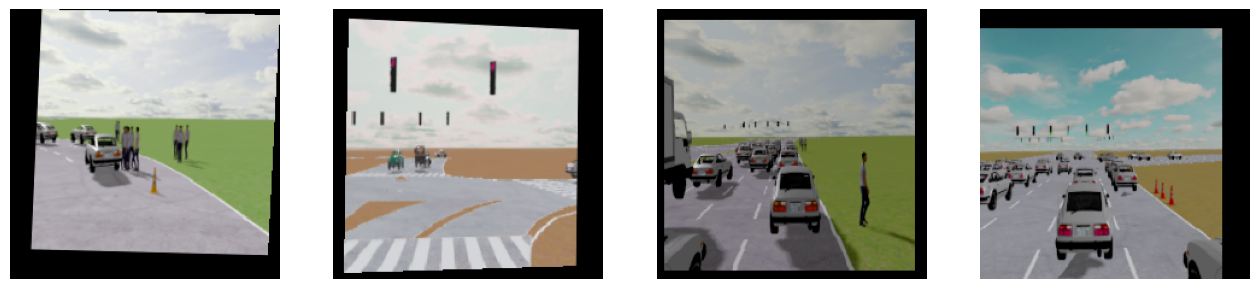

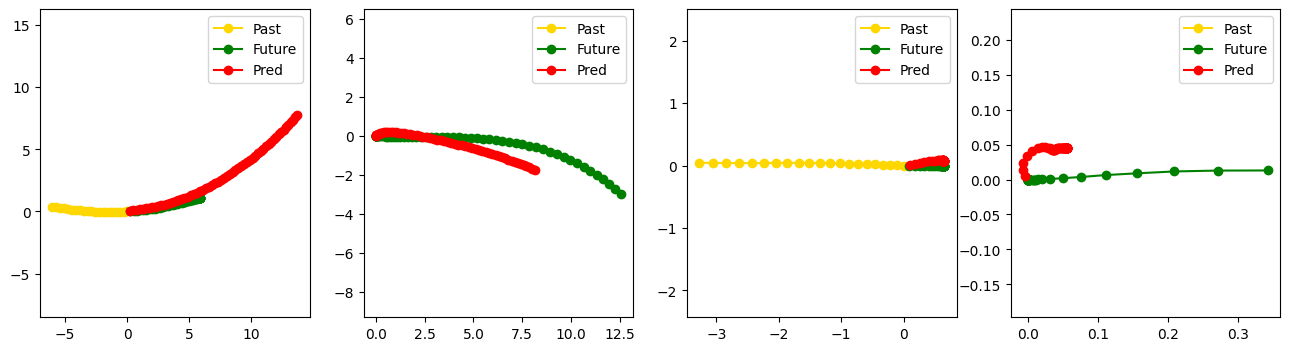

In [23]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)
command = val_batch_zero["command"].to(device)

# Normalization stats for x, y (assumed)
TRAJ_MEAN = np.array([14.33438059, 0.17988126])
TRAJ_STD = np.array([16.65811211, 2.70226038])

model.load_state_dict(torch.load('best_model.pt'))
model.eval()
with torch.no_grad():
    pred = model(camera, history, command)
    best_pred = pred  # no mode selection needed


# Move to CPU
camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
command = command.cpu().numpy()
best_pred = best_pred.cpu().numpy()

# Denormalize x, y (heading is left untouched)
history[:, :, :2] = history[:, :, :2]
future[:, :, :2] = future[:, :, :2]
best_pred[:, :, :2] = best_pred[:, :, :2]


# Visualize
k = 4
selected_indices = random.sample(range(len(camera)), k)

# --- Camera images ---
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    img = camera[idx].transpose(1, 2, 0)
    axis[i].imshow(img)
    axis[i].axis("off")
plt.show()

# --- Trajectories + Heading ---
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    ax = axis[i]
    ax.plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    ax.plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    ax.plot(best_pred[idx, :, 0], best_pred[idx, :, 1], "o-", color="red", label="Pred")

    ax.axis("equal")
    ax.legend()
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [21]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [22]:
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)

TRAJ_MEAN = np.array([14.3343806, 0.17988126])
TRAJ_STD  = np.array([16.65811211, 2.70226038])

model.load_state_dict(torch.load('best_model.pt'))
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        command = batch['command'].to(device)

        pred_future = model(camera, history, command)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)
# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape

pred_xy_flat = pred_xy.reshape(total_samples, T * D)
# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.extend([f"x_{t}", f"y_{t}"])
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1_DC.csv", index=False)
print(f"Submission CSV shape: {df_xy.shape}")


# Load the CSV
df = pd.read_csv("submission_phase1_DC.csv")

# Identify x and y columns
x_cols = [col for col in df.columns if col.startswith("x_")]
y_cols = [col for col in df.columns if col.startswith("y_")]

# Compute max and min
max_x = df[x_cols].max().max()
min_x = df[x_cols].min().min()
max_y = df[y_cols].max().max()
min_y = df[y_cols].min().min()

print(f"🟥 X-axis: min = {min_x:.2f}, max = {max_x:.2f}")
print(f"🟦 Y-axis: min = {min_y:.2f}, max = {max_y:.2f}")

Submission CSV shape: (1000, 121)
🟥 X-axis: min = -0.23, max = 86.22
🟦 Y-axis: min = -26.03, max = 22.11
